In [1]:
import hdbscan
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt

In [2]:
# load messages
messages = pd.read_csv('messages_100k.csv')
messages = messages['message'].tolist()

In [4]:
# get BERT embeddings
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(messages, show_progress_bar=True)

In [5]:
embeddings.shape

(100000, 768)

In [6]:
# use UMAP to reduce dimensions
umapper = umap.UMAP(n_neighbors=15, n_components=5, metric='cosine')
umap_embeddings = umapper.fit_transform(embeddings)

In [8]:
umap_embeddings.shape

(100000, 5)

In [9]:
# cluster using HDBSCAN
hdbscanner = hdbscan.HDBSCAN(min_cluster_size=15,
    metric='euclidean', cluster_selection_method='eom')
cluster = hdbscanner.fit(umap_embeddings)

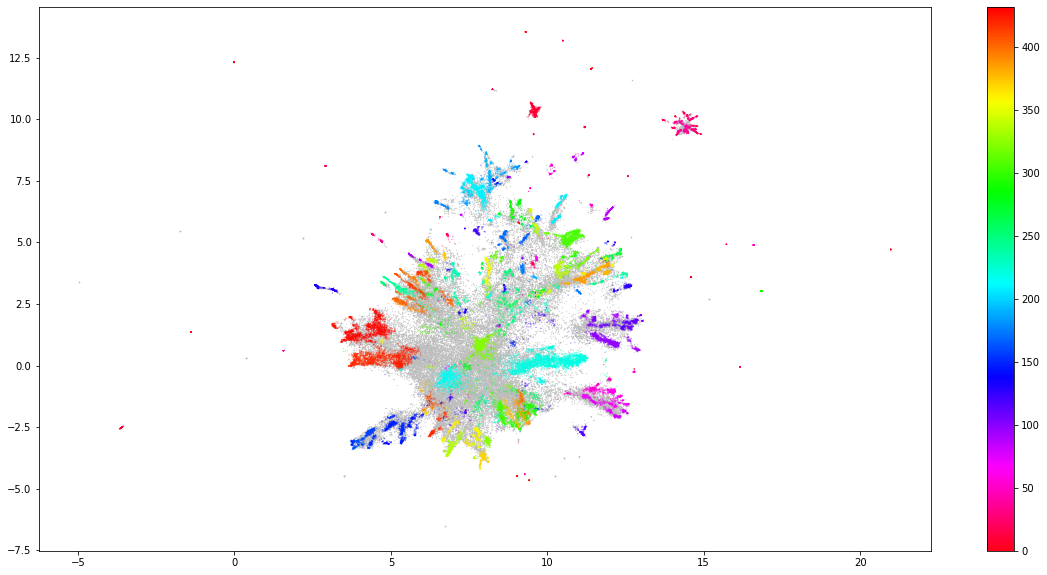

In [10]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(
    embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [57]:
docs_df = pd.DataFrame(messages, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [41]:
docs_per_topic.head()

,Topic,Doc
0,-1,Is the offer still available of 6 weeks free a...
1,0,"null, reduce pain, anxiety , inflammation with..."
2,1,"Diederich, Powerful, Natural relief TUMERIC + ..."
3,2,I would prefer to be contacted via text messag...
4,3,Hi I'm Devin! I would like to schedule a tour!...


In [14]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [16]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(messages))

In [29]:
tf_idf.shape

(37253, 434)

In [17]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [18]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [33]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)

In [34]:
topic_sizes.head(15)

,Topic,Size
0,-1,63330
221,220,2801
431,430,1332
421,420,1256
308,307,1025
211,210,926
99,98,891
216,215,840
324,323,692
10,9,686


In [70]:
for text in docs_df[docs_df['Topic'] == 307]['Doc']:
    print(f"{text}\n====\n")

How much is an assigned parking spot?
====

Thank you! Which parking number is ours?
====

Van you email me about parking costs and process asap? Thanks
====

How much is the security deposit? Is parking an additional fee?
====

Hello! I have a car so I am interested in parking as well. Can I swing by to take a look at the apt? Thanks!
====

And do they come with parking and laundry
====

Hi I was wondering how many parking spots come with the apartment?
====

What is the price for that unit? That's the downtown la location right?
====

How much are the studios?
Is there parking?
====

how much is parking, is storage available, and are the units air conditioned?
====

Hi how does parking work for guest?
====

Hi - I would like more information on this building.  Is parking available? thank you
====

Hi, What's the promotional pricing on this unit? Does it face Manhattan?
====

Thank you. 
Also, how many parking spots are guaranteed and are additional parking spots available for an extr

In [20]:
top_n_words[220][:10]

[('dog', 0.14700427217706363),
 ('dogs', 0.09928566590608745),
 ('pet', 0.07861027202093149),
 ('small', 0.06066717094176039),
 ('policy', 0.03859910904248168),
 ('friendly', 0.03782092614245757),
 ('pets', 0.03621423467829894),
 ('breed', 0.03442081363170202),
 ('restrictions', 0.02973012634012449),
 ('allow', 0.029487416939318573)]

In [21]:
top_n_words[430][:10]

[('reschedule', 0.22557118879367738),
 ('cancel', 0.17735441812507605),
 ('sorry', 0.1436949518633068),
 ('appointment', 0.1288796059258565),
 ('today', 0.09046514236016893),
 ('need', 0.060593711509401696),
 ('make', 0.05458567011371077),
 ('tour', 0.048762595328944044),
 ('unfortunately', 0.04689175912746601),
 ('tomorrow', 0.0414723760671339)]

In [22]:
top_n_words[420][:10]

[('don', 0.038705675881512594),
 ('website', 0.035135658820128444),
 ('apply', 0.03500931693770615),
 ('application', 0.031752308584940936),
 ('didn', 0.031114946126771167),
 ('link', 0.029988332701725053),
 ('tried', 0.029073927098990027),
 ('email', 0.02687947509539338),
 ('tour', 0.026580666427868067),
 ('just', 0.02431028854275202)]

In [23]:
top_n_words[307][:10]

[('parking', 0.48627863805579924),
 ('does', 0.06683685441749163),
 ('spot', 0.06668099358956159),
 ('included', 0.06531259482134534),
 ('garage', 0.0624689025103553),
 ('assigned', 0.05899326902899828),
 ('covered', 0.05758978421914033),
 ('hi', 0.03757179571485296),
 ('situation', 0.037419034121724086),
 ('spots', 0.036204469958520565)]

In [24]:
top_n_words[210][:10]

[('viewing', 0.15125499691821712),
 ('unit', 0.14180733554170205),
 ('come', 0.09628630747066311),
 ('schedule', 0.08954826905049257),
 ('hi', 0.08693887685284826),
 ('view', 0.08494342757292038),
 ('available', 0.08234062671672857),
 ('interested', 0.07465364715211834),
 ('thanks', 0.07439097716286261),
 ('like', 0.06909579398476756)]

In [25]:
top_n_words[98][:10]

[('bath', 0.3278284076527997),
 ('bed', 0.1956748169937272),
 ('bedroom', 0.08614950203379625),
 ('bathroom', 0.07106519315771401),
 ('looking', 0.07102341692948629),
 ('interested', 0.06394403741910647),
 ('bedrooms', 0.054108937647946095),
 ('floor', 0.051023532336305306),
 ('available', 0.048651714149346485),
 ('like', 0.04709696641059016)]

In [26]:
top_n_words[215][:10]

[('pets', 0.09366904952801415),
 ('looking', 0.04406651192433982),
 ('don', 0.028665321074311793),
 ('bedroom', 0.028597286778949637),
 ('date', 0.028309620569535378),
 ('apartment', 0.024536748585336388),
 ('budget', 0.024372876801277542),
 ('month', 0.023170104248520427),
 ('lease', 0.019626821645550994),
 ('washer', 0.01935318258302779)]

In [27]:
top_n_words[323][:10]

[('nyc', 0.10472346500891788),
 ('new', 0.04977783534845953),
 ('york', 0.047718387059786115),
 ('moving', 0.04405898630356058),
 ('brooklyn', 0.03456521234429203),
 ('looking', 0.03378225916990415),
 ('apartment', 0.032071485489430035),
 ('interested', 0.023765081786568405),
 ('currently', 0.02303713244916762),
 ('manhattan', 0.0225748071503291)]

In [28]:
top_n_words[9][:10]

[('section', 0.7023826550912999),
 ('accept', 0.3685440846614454),
 ('voucher', 0.15481882331527244),
 ('vouchers', 0.14403431922191748),
 ('housing', 0.0666233445065135),
 ('hi', 0.05403588703592659),
 ('guys', 0.04936678973933596),
 ('accepted', 0.04223849871558671),
 ('know', 0.041633675605434725),
 ('hello', 0.03775121931524638)]

In [35]:
top_n_words[305][:10]

[('june', 0.34771021844162486),
 ('1st', 0.08652130211106737),
 ('available', 0.07594542680729652),
 ('date', 0.06459253750874254),
 ('looking', 0.06268815703112181),
 ('interested', 0.05997857437557785),
 ('mid', 0.05473311043364945),
 ('july', 0.04626982661927705),
 ('apartment', 0.045003571820455175),
 ('hi', 0.044909139026315915)]

In [37]:
top_n_words[242][:10]

[('week', 0.4370694049919721),
 ('viewing', 0.08041559699628535),
 ('schedule', 0.07633748870467458),
 ('come', 0.06247462296398443),
 ('apartment', 0.056166619390198),
 ('possible', 0.05591156027258358),
 ('interested', 0.05304431824484921),
 ('hi', 0.051853391598516166),
 ('view', 0.04721691136501661),
 ('let', 0.04661707974436757)]

In [38]:
top_n_words[336][:10]

[('month', 0.37196021301342796),
 ('lease', 0.3192282193930093),
 ('leases', 0.1388673568845853),
 ('offer', 0.10016473040362547),
 ('months', 0.08437955471496307),
 ('term', 0.07383308136866609),
 ('short', 0.06019899658934707),
 ('looking', 0.03855362174261146),
 ('available', 0.0376730780025105),
 ('option', 0.03759067649479013)]

In [39]:
top_n_words[294][:10]

[('bedroom', 0.17460309907190613),
 ('september', 0.10678528740856122),
 ('august', 0.10616831394997459),
 ('july', 0.10553295336658668),
 ('looking', 0.1008386260403799),
 ('1st', 0.08802586920928562),
 ('available', 0.07853396387986294),
 ('june', 0.06906559495944192),
 ('date', 0.061396616031351596),
 ('mid', 0.057297391925348676)]

In [40]:
top_n_words[387][:10]

[('apartment', 0.2388572716779353),
 ('interested', 0.12081887340058017),
 ('view', 0.11402604062134337),
 ('viewing', 0.10162982225235158),
 ('hi', 0.09710027700818434),
 ('thanks', 0.08658375016056834),
 ('love', 0.07160521420726675),
 ('seeing', 0.06746958530996282),
 ('let', 0.06640883575342882),
 ('hello', 0.06412490144383035)]

In [31]:
len(top_n_words)

434

Conclusion: Topics are very targeted, but they don't catch a lot.